In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
data = pd.read_csv("supplier_rank_prediction_lstm.csv", 
                      usecols = [1], 
                      engine = "python", 
                      skipfooter = 3)

In [15]:
data.head()

,RANKING_1M_ALERTE
0,20.2
1,20.2
2,20.2
3,20.2
4,20.2


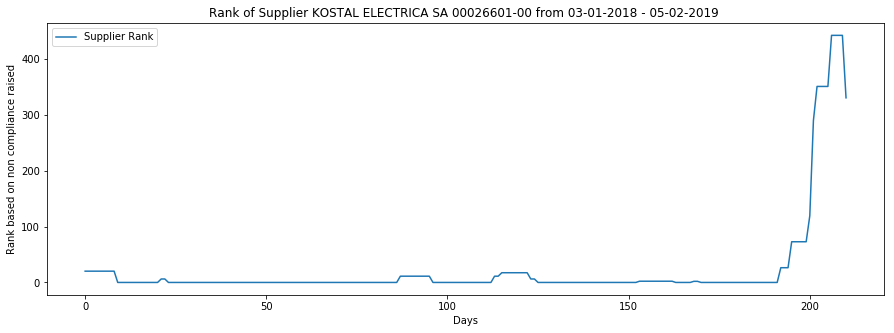

In [27]:
plt.figure(figsize = (15, 5))
plt.plot(data, label = "Supplier Rank")
plt.xlabel("Days")
plt.ylabel("Rank based on non compliance raised")
plt.title("Rank of Supplier KOSTAL ELECTRICA SA 00026601-00 from 03-01-2018 - 05-02-2019 ")
plt.legend()
plt.show()


In [17]:
# Let's load the required libs.
# We'll be using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

In [18]:
# Get the raw data values from the pandas data frame.
data_raw = data.values.astype("float32")

# We apply the MinMax scaler from sklearn
# to normalize data in the (0, 1) interval.
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(data_raw)

# Print a few values.
dataset[0:5]

array([[0.04563941],
       [0.04563941],
       [0.04563941],
       [0.04563941],
       [0.04563941]], dtype=float32)

In [19]:
# Using 60% of data for training, 40% for validation.
TRAIN_SIZE = 0.60

train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (126, 85)


In [20]:
# FIXME: This helper function should be rewritten using numpy's shift function. See below.
def create_dataset(dataset, window_size = 1):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))

In [21]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(124, 1)
New training data shape:
(124, 1, 1)


In [22]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 100, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

Epoch 1/100
 - 2s - loss: 2.4974e-04
Epoch 2/100
 - 1s - loss: 2.3474e-04
Epoch 3/100
 - 1s - loss: 2.2570e-04
Epoch 4/100
 - 1s - loss: 2.1352e-04
Epoch 5/100
 - 1s - loss: 1.9981e-04
Epoch 6/100
 - 1s - loss: 1.7819e-04
Epoch 7/100
 - 1s - loss: 1.5791e-04
Epoch 8/100
 - 1s - loss: 1.2399e-04
Epoch 9/100
 - 1s - loss: 1.0689e-04
Epoch 10/100
 - 1s - loss: 8.2079e-05
Epoch 11/100
 - 1s - loss: 7.0255e-05
Epoch 12/100
 - 1s - loss: 5.6170e-05
Epoch 13/100
 - 1s - loss: 5.0221e-05
Epoch 14/100
 - 1s - loss: 4.4476e-05
Epoch 15/100
 - 1s - loss: 4.8892e-05
Epoch 16/100
 - 1s - loss: 4.4993e-05
Epoch 17/100
 - 1s - loss: 4.4641e-05
Epoch 18/100
 - 1s - loss: 4.8920e-05
Epoch 19/100
 - 1s - loss: 4.6083e-05
Epoch 20/100
 - 1s - loss: 4.5135e-05
Epoch 21/100
 - 1s - loss: 4.3019e-05
Epoch 22/100
 - 1s - loss: 4.3620e-05
Epoch 23/100
 - 1s - loss: 4.5687e-05
Epoch 24/100
 - 1s - loss: 4.6826e-05
Epoch 25/100
 - 1s - loss: 4.5231e-05
Epoch 26/100
 - 1s - loss: 4.5957e-05
Epoch 27/100
 - 1s - 

In [23]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = scaler.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = scaler.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 2.78 RMSE
Test data score: 34.28 RMSE


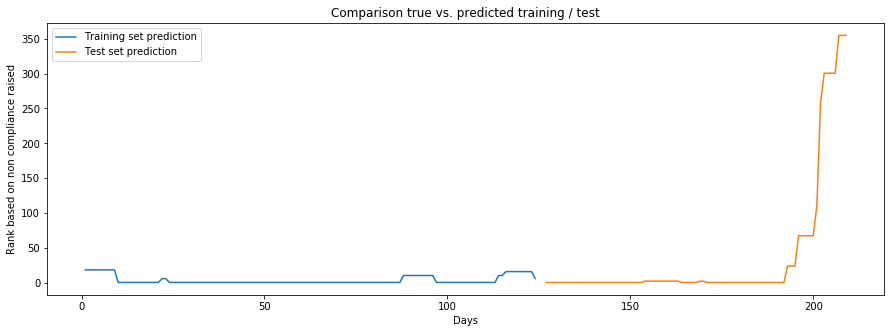

In [26]:
# Create the plot.
plt.figure(figsize = (15, 5))
#plt.plot(scaler.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Days")
plt.ylabel("Rank based on non compliance raised")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()